# 1. feladat

Az https://archive.ics.uci.edu/ml/machine-learning-databases/00272/SkillCraft1_Dataset.csv adatbázis StarCraft2 játékosok statisztikáit tartalmazza. Kérdés, hogy ezekből az adatokból mennyire jelezhető előre, hogy melyik ligában játszik a játékos.

Hajts végre regressziós gépi tanulási kísérletet a `LeagueIndex` célváltozón (1-8 intervallum), úgy hogy a `GameID > 7000` játékosokat használod kiértékelő adatbázisnak.

Vigyázz! Az adatbázisban `?` jelöli a hiányzó értékeket.


In [4]:
import pandas as pd
# töltsük be az adatbázist
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00272/SkillCraft1_Dataset.csv",na_values="?")
df.head() # nézzünk rá!

df.describe()
df[df.GameID > 7000].shape #kiértékelő adathalmaz mérete

df=df.dropna() #mivel vannak NAN értékek az adatbázisban, most kidobjuk őket, hogy ne okozzanak gondot később
df.shape #az egész adatbázis mérete

features = df.loc[:,"Age":]
df.loc[:,"Age":] # jellemzők az Age változó szerint

# szétválasztjuk a tanító- és teszthalmazokat, különvéve a jellemzőket és az osztálycímkét
trainFeatures = df[df.GameID <= 7000].loc[:,"Age":] # A 7000-nél kisebb egyenlőek Age szerint, tanító adatbázis része
trainLabels = df[df.GameID <= 7000].LeagueIndex # A 7000-nél kisebb egyenlőek osztálycímke(LeagueIndex) szerint, tanító adatbázis része
testFeatures = df[df.GameID > 7000].loc[:,"Age":] # A 7000-nél nagyobbak Age szerint a kiértékelő adatbázison
testLabels =  df[df.GameID > 7000].LeagueIndex # A 7000-nél nagyobbak a célváltozó szerint a kiértékelő adatbázison

from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(min_samples_leaf=50) #DecisionTreeRegressor (azaz döntési fa regresszióra) használata
dt.fit(trainFeatures, trainLabels) # tanítás a tanító adatbázison
prediction = dt.predict(testFeatures) # predikció a kiértékelő adatbázison

from sklearn.metrics import mean_squared_error # MSE (RMSE végső gyökvonás nélkül)
mean_squared_error(prediction, testLabels) #MSE meghatározása

from sklearn.dummy import DummyRegressor
dummy = DummyRegressor(strategy='mean') # tanító adatbázis címkéinek átlaga lesz mindig a predikció
dummy.fit(trainFeatures, trainLabels)
mean_squared_error(dummy.predict(testFeatures), testLabels)



2.009929291790602

# 2. feladat
Melyik jellemző a legfontosabb a regressziós modellben?

Építs erre az egy jellemzőre egy döntési modellt (akár kézzel szabály-alapon, akár gépi tanulva)!

In [5]:
dt = DecisionTreeRegressor(max_depth=1)

dt.fit(trainFeatures, trainLabels) # tanítás a tanító adatbázison

root = dt.tree_.feature[0] # gyökércsúcsban lévő feature indexe
trainFeatures.columns[root] # a legfontosabb jellemző kinyerése

root = dt.tree_.feature[0] # gyökércsúcsban lévő feature indexe
trainFeatures.columns[root] # a legfontosabb jellemző kinyerése

prediction = dt.predict(testFeatures) # predikció a kiértékelő adathalmazon
mean_squared_error(prediction, testLabels)

1.458830846337093

# 3. feladat
Próbálj ki egy másik regressziós algoritmust is az 1. feladatra. Mindkét módszernek hangold be a meta-paraméterit. (bónus feladat: a meta-paraméter értékekre a túltanási ábra kirajzolása)

A végén szövegként írd le, hogy a két algoritmus közül melyik a jobb!


In [7]:
# az előzőekben a Decision Tree Regressort alkalmaztam, most a Random Forest Regressort fogom alkalmazni
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Random Forest regresszor
rf = RandomForestRegressor(random_state=42)

# Meta-paraméterek grid search-hoz
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=2)
grid_search.fit(trainFeatures, trainLabels)

# Legjobb paraméterek és modell
best_rf = grid_search.best_estimator_
print("Legjobb paraméterek:", grid_search.best_params_)

# Kiértékelés
rf_prediction = best_rf.predict(testFeatures)
rf_mse = mean_squared_error(testLabels, rf_prediction)
print("Random Forest MSE:", rf_mse)


Legjobb paraméterek: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest MSE: 0.8537282241040721


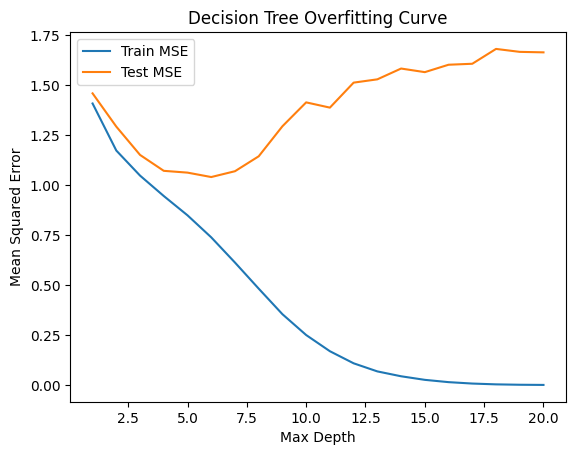

In [8]:
import matplotlib.pyplot as plt
import numpy as np

train_errors = []
test_errors = []

max_depths = range(1, 21)
for depth in max_depths:
    dt = DecisionTreeRegressor(max_depth=depth)
    dt.fit(trainFeatures, trainLabels)
    train_errors.append(mean_squared_error(trainLabels, dt.predict(trainFeatures)))
    test_errors.append(mean_squared_error(testLabels, dt.predict(testFeatures)))

plt.plot(max_depths, train_errors, label="Train MSE")
plt.plot(max_depths, test_errors, label="Test MSE")
plt.xlabel("Max Depth")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.title("Decision Tree Overfitting Curve")
plt.show()


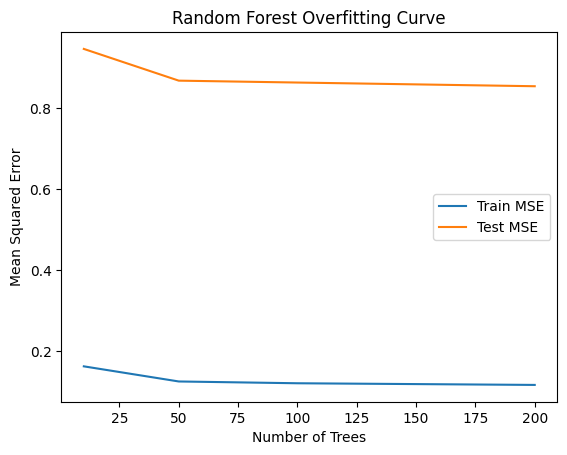

In [9]:
train_errors = []
test_errors = []

n_estimators_range = [10, 50, 100, 200]
for n_estimators in n_estimators_range:
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    rf.fit(trainFeatures, trainLabels)
    train_errors.append(mean_squared_error(trainLabels, rf.predict(trainFeatures)))
    test_errors.append(mean_squared_error(testLabels, rf.predict(testFeatures)))

plt.plot(n_estimators_range, train_errors, label="Train MSE")
plt.plot(n_estimators_range, test_errors, label="Test MSE")
plt.xlabel("Number of Trees")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.title("Random Forest Overfitting Curve")
plt.show()
